In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.io import read_image

import zipfile
from tqdm.notebook import tqdm, trange

import shutil
import os
import pandas as pd
from IPython.display import display
import json
import time



In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# extract data from zip file
zipPath = '/content/drive/MyDrive/kursinis/Data4.zip'
targetPath = '/content'

with zipfile.ZipFile(zipPath, 'r') as zip_ref:
    zip_ref.extractall(targetPath)

In [ ]:
df = pd.read_csv('/content/Data/data.csv');

In [ ]:
actions = {
    '[0, 0, 0]': 0,   # None
    '[-1, 0, 0]': 1,  # Left
    '[1, 0, 0]': 2,   # Right
    '[0, 1, 0]': 3,   # Forward
    '[0, 0, 1]': 4,   # Backward
}

In [ ]:
actionsLabels = {
    0: 'None',
    1: 'Left',
    2: 'Right',
    3: 'Forward',
    4: 'Backward',
}

In [ ]:
df['action'] = df['action'].shift(-3)
df = df.iloc[:-3]

In [ ]:
print(len(df))
df = df[df['action'] != 'action']
print(len(df))

100446
100446


In [ ]:
df['action'] = df['action'].map(actions)

In [ ]:
df[df['action'] == 1]

,image,action,reward
71,image_71.png,1,3.189474
72,image_72.png,1,-0.100000
73,image_73.png,1,-0.100000
74,image_74.png,1,-0.100000
75,image_75.png,1,3.189474
...,...,...,...
100299,image_100299.png,1,-0.100000
100300,image_100300.png,1,3.775969
100301,image_100301.png,1,-0.100000
100357,image_100357.png,1,-0.100000


In [ ]:
def getImagesAndLabels(dataFrame, imageColName, labelColName, imagesRoot, count):
  dataToGet = dataFrame.iloc[: count]
  imagePaths = [os.path.join(imagesRoot, imagePath[1]) for imagePath in dataToGet[imageColName].iteritems()]
  images = torch.stack([read_image(path) for path in imagePaths])

  labels = [label[1] for label in dataToGet[labelColName].iteritems()]

  return images, labels

In [ ]:
def convertLabelsToHumanReadible(labels):
  return list(map(lambda labelID: actionsLabels.get(labelID), labels))

In [ ]:
def plot_images(images, labels):
  count = len(images);

  rows = int(np.sqrt(count))
  cols = int(np.sqrt(count))

  fig = plt.figure(figsize=(10, 10))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)

    image = images[i];
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(labels[i])
    ax.axis('off')

In [ ]:
count = 10000

none = df[df['action'] == 0][:count +16500]
left = df[df['action'] == 1][:count]
right = df[df['action'] == 2][:count]
forward = df[df['action'] == 3][:count]
backward = df[df['action'] == 4][:count]

all_actions = pd.concat([none, left, right, forward])

In [ ]:
# split data for training and validation

valRatio = 0.9
trainData = all_actions.sample(frac=valRatio)
validationData = all_actions.drop(trainData.index)

In [ ]:
#Traning data
display(trainData['action'].value_counts()/44896)

0    0.531228
1    0.200218
2    0.147875
3    0.120679
Name: action, dtype: float64

In [ ]:
#Validation data
display(validationData['action'].value_counts())

0    2650
1    1011
2     740
3     588
Name: action, dtype: int64

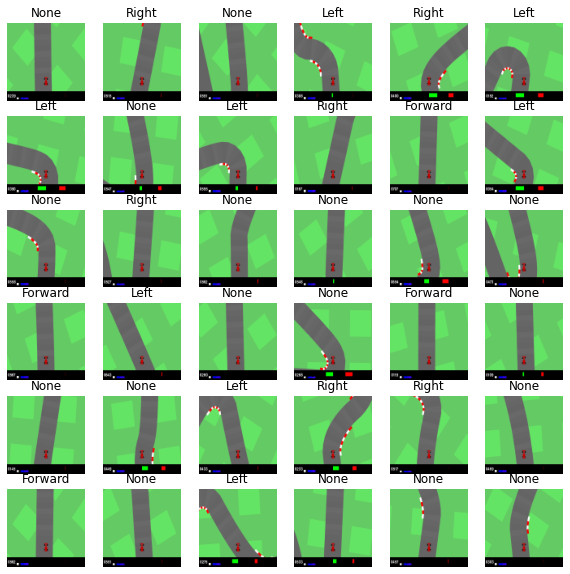

In [ ]:
# Sample of training data
training_sample = trainData.sample(40)
images, labels = getImagesAndLabels(training_sample, 'image', 'action','/content/Data', len(training_sample) )
plot_images(images, convertLabelsToHumanReadible(labels))

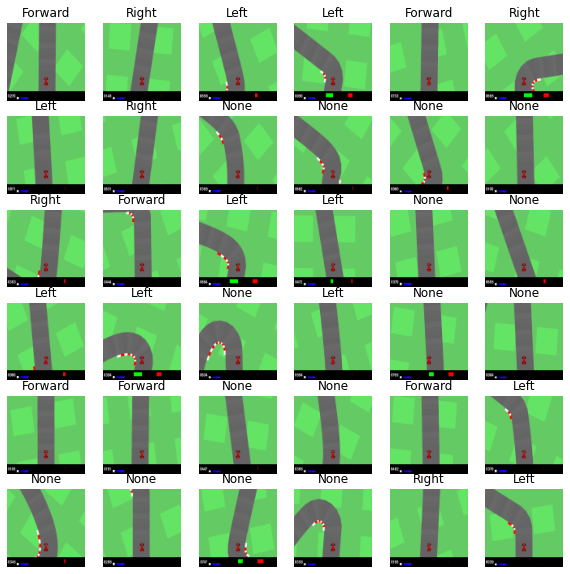

In [ ]:
# Sample of validation data
validataionSample = validationData.sample(40)
images, labels = getImagesAndLabels(validataionSample, 'image', 'action','/content/Data', len(validataionSample) )
plot_images(images, convertLabelsToHumanReadible(labels))

In [ ]:
# Get training images and labels
training_images, training_labels = getImagesAndLabels(trainData, 'image', 'action','/content/Data', len(all_actions) )
training_images = training_images.double() / 255

print(len(training_images))

44896


In [ ]:
# Get validation images and labels

validation_images, validation_labels = getImagesAndLabels(validationData, 'image', 'action','/content/Data', len(validationData) )
validation_images = validation_images.double() / 255

print(len(validation_images))

4989


In [ ]:
# calculate mean and standard deviation for normalizing data
means = torch.mean(training_images, [0,2,3])
stds = torch.std(training_images, [0,2,3])

torch.set_printoptions(precision=50)
print(means, stds)

tensor([0.35095252524827164064546991539828013628721237182617,
        0.62993200810009264412059337701066397130489349365234,
        0.34853906347356833350659144343808293342590332031250],
       dtype=torch.float64) tensor([0.13510250327375294965293051063781604170799255371094,
        0.29078223911179923444336736793047748506069183349609,
        0.13344167387197022889289144131907960399985313415527],
       dtype=torch.float64)


In [ ]:
data_transform = transforms.Compose([
                              transforms.Normalize(mean=means,
                                                  std=stds)])

In [ ]:
class CarRacingDataset(Dataset):
    def __init__(self, images, labels, transform=None ):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        return (image, label)

In [ ]:
#Create training and validation datasets
batch_size = 100

trainingDataset = CarRacingDataset(images=training_images, labels=training_labels, transform=data_transform)
validationDataset = CarRacingDataset(images=validation_images, labels=validation_labels, transform=data_transform)


In [ ]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

In [ ]:
device

'cuda'

In [ ]:
model = AlexNet(5)
model = model.to(device)

In [ ]:
from torchsummary import summary
summary(model, (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           1,792
         MaxPool2d-2           [-1, 64, 24, 24]               0
              ReLU-3           [-1, 64, 24, 24]               0
            Conv2d-4          [-1, 192, 24, 24]         110,784
         MaxPool2d-5          [-1, 192, 12, 12]               0
              ReLU-6          [-1, 192, 12, 12]               0
            Conv2d-7          [-1, 384, 12, 12]         663,936
              ReLU-8          [-1, 384, 12, 12]               0
            Conv2d-9          [-1, 256, 12, 12]         884,992
             ReLU-10          [-1, 256, 12, 12]               0
           Conv2d-11          [-1, 256, 12, 12]         590,080
        MaxPool2d-12            [-1, 256, 6, 6]               0
             ReLU-13            [-1, 256, 6, 6]               0
          Dropout-14                 [-

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

In [ ]:
#create validation and training dataloaders

training_loader = torch.utils.data.DataLoader(trainingDataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validationDataset, batch_size=batch_size)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device, dtype=torch.float)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device, dtype=torch.float)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 20

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, training_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, validation_loader, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 1.115 | Train Acc: 50.69%
	 Val. Loss: 0.837 |  Val. Acc: 63.55%


Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 0.737 | Train Acc: 70.77%
	 Val. Loss: 0.608 |  Val. Acc: 76.05%


Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 0.615 | Train Acc: 76.26%
	 Val. Loss: 0.573 |  Val. Acc: 77.65%


Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 15s
	Train Loss: 0.578 | Train Acc: 77.66%
	 Val. Loss: 0.540 |  Val. Acc: 78.60%


Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 15s
	Train Loss: 0.558 | Train Acc: 78.38%
	 Val. Loss: 0.515 |  Val. Acc: 80.20%


Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 15s
	Train Loss: 0.543 | Train Acc: 78.73%
	 Val. Loss: 0.509 |  Val. Acc: 80.60%


Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 15s
	Train Loss: 0.532 | Train Acc: 79.48%
	 Val. Loss: 0.502 |  Val. Acc: 80.35%


Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 15s
	Train Loss: 0.522 | Train Acc: 79.80%
	 Val. Loss: 0.491 |  Val. Acc: 80.55%


Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 15s
	Train Loss: 0.510 | Train Acc: 80.61%
	 Val. Loss: 0.481 |  Val. Acc: 80.65%


Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 15s
	Train Loss: 0.499 | Train Acc: 80.65%
	 Val. Loss: 0.473 |  Val. Acc: 81.05%


Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 15s
	Train Loss: 0.497 | Train Acc: 80.74%
	 Val. Loss: 0.470 |  Val. Acc: 81.00%


Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 15s
	Train Loss: 0.485 | Train Acc: 80.91%
	 Val. Loss: 0.478 |  Val. Acc: 81.40%


Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 15s
	Train Loss: 0.483 | Train Acc: 81.23%
	 Val. Loss: 0.462 |  Val. Acc: 81.55%


Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 15s
	Train Loss: 0.476 | Train Acc: 81.51%
	 Val. Loss: 0.460 |  Val. Acc: 82.25%


Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 15s
	Train Loss: 0.470 | Train Acc: 82.02%
	 Val. Loss: 0.443 |  Val. Acc: 81.95%


Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 15s
	Train Loss: 0.468 | Train Acc: 81.82%
	 Val. Loss: 0.445 |  Val. Acc: 82.00%


Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 15s
	Train Loss: 0.466 | Train Acc: 81.71%
	 Val. Loss: 0.444 |  Val. Acc: 82.20%


Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 15s
	Train Loss: 0.459 | Train Acc: 82.11%
	 Val. Loss: 0.446 |  Val. Acc: 82.50%


Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 16s
	Train Loss: 0.456 | Train Acc: 82.47%
	 Val. Loss: 0.442 |  Val. Acc: 82.45%


Training:   0%|          | 0/180 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 15s
	Train Loss: 0.453 | Train Acc: 82.46%
	 Val. Loss: 0.433 |  Val. Acc: 83.00%


In [ ]:
torch.save(model, '/content/drive/MyDrive/kursinis/model_car_104.pt')

In [ ]:
torch.set_printoptions(profile="full")
image = read_image('/content/Test/image_81.png')
image = image.double() /255
image = data_transform(image).to(device, dtype=torch.float)
# print(image)
image = image[None, :]
model.eval()
pred, _ = model(image)
idx = torch.argmax(F.softmax(pred, dim=-1))
idx = idx.item()
print(idx)

model_loaded = torch.load('/content/drive/MyDrive/kursinis/model_car14.pt', map_location='cpu')
model_loaded.to(device)
model_loaded.eval()
pred_loaded, _ = model_loaded(image)
idx_loaded = torch.argmax(F.softmax(pred_loaded, dim=-1))
idx_loaded = idx_loaded.item()
print(idx_loaded)


In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [ ]:
! rm -rf /content/Test/